In [299]:
# Import Libraries
# =========================================================

import numpy as np
import pandas as pd
from collections import Counter
from itertools import product
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
from heatmap import heatmap, corrplot

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## GLOBAL SETTINGS
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.2f}".format
plt.rcParams["savefig.bbox"] = "tight"

In [122]:
def missing_summary(data):
    has_non = 0
    for column in data.columns:
        total_values = len(data)
        missing_values = data[column].isnull().sum()
        percentage = ((missing_values/total_values)*100).round(2)
        if missing_values > 0:
            print('df["{}"] - Total values: {}, Missing values: {} ({}%)'.format(column, total_values, missing_values, percentage,))
        else:
            has_non += 1
    if has_non == len(data.columns):
        print("Provided dataframe does not have any missing values.")

# =========================================================
def outliers(data):
    numeric_features = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    for col in numeric_features:
        temp = data.copy()
        temp.dropna(axis = 0, subset = [col], inplace = True)
        mini, maxi = temp[col].min(), temp[col].max()
        Q1, Q3 = np.quantile(temp[col], 0.25), np.quantile(temp[col], 0.75)
        IQR = Q3 - Q1
        lower_range, upper_range = (Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR)
        outliers_upper = len(temp[temp[col] > upper_range])
        outliers_lower = len(temp[temp[col] < lower_range])
        print('df["{}"]'.format(col))
        print("Min: {}, Max: {}, Q1: {}, Q3: {}".format(mini, maxi, Q1, Q3))
        print("IQR: {}" .format(IQR))
        print("LOWER/UPPER Range: {} / {}" .format (lower_range, upper_range))
        print("Total LOWER/UPPER outliers: {} / {}\n".format (outliers_lower, outliers_upper))

# =========================================================
def categorical_counter(data):
    for column in data.select_dtypes(exclude = np.number).columns:
        cat_length = len(data[column].unique())
        print(f"df[\"{column}\"] contains {cat_length} unique values.")

# =========================================================
def numerical_distribution(df,feature, feature_2):
    
    print(f"{feature} Overview:")
    integers = range(len(df[feature]))
    fig = sns.scatterplot(data = df, 
        x = integers, 
        y = feature, 
        hue = feature_2, 
        style = feature_2)
 
    print(99*"#")
    quartile_1, quartile_3 = np.percentile(df[feature], [25, 75])
    IQR= quartile_3 - quartile_1
   
    median = np.median(df[feature])
    absolute_deviations = np.abs(df[feature] - median)
    median_absolute_deviation = np.median(absolute_deviations)
    mcv = median_absolute_deviation / median

    print(f"Summary statistics\n {df[[feature]].describe()}")
    print()
    print('Outliers analysis:\n')
    print(f'IQR: {IQR} || (median_abs_deviation): {median_absolute_deviation}|| The Median-based index: {mcv} ')

# =========================================================
def feature_vs_target_w_lengh(data, feature, TARGET, active_customers = True, grouped = True):

    title_sub = ""
    if active_customers == True:
        data[data["active_customer"] == 1]
        title_sub = "Active customers - "
    if grouped == True:
        data = data.drop_duplicates(subset = "pk_cid", keep = "last")
        title_sub = "Unique " + title_sub
    
    sleep_pivot = data.pivot_table(
        index = [feature], values = TARGET,
        aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

    fig, ax = plt.subplots()
    scatter = ax.scatter(
        sleep_pivot.index, sleep_pivot[("mean", TARGET)], c = sleep_pivot[("len", TARGET)], 
        cmap = "viridis", alpha = 0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel(TARGET + " rate")
    ax.set_title(title_sub + " " + feature + " vs " + TARGET + " Rate")
    cbar = fig.colorbar(scatter)
    cbar.set_label("len")
    plt.show()

# =========================================================
def four_feature_scatterer(data, category, aggfunc, title = "Title", grouped = True):
    if grouped == True:
        df_prep = data.groupby(["pk_cid", category]).agg(aggfunc).reset_index()
        vis_data = df_prep.groupby(category).agg(aggfunc).sort_values(by = list(aggfunc.keys())[2], ascending = False)
    else:
        vis_data = data.groupby(category).agg(aggfunc).sort_values(by = list(aggfunc.keys())[2], ascending = False)
        
    fig = px.scatter(
        vis_data, 
        x = list(aggfunc.keys())[0], 
        y = list(aggfunc.keys())[1], 
        color = vis_data.index, 
        size = list(aggfunc.keys())[2])
    fig.update_layout(
        barmode = "overlay",
        title = { "text": title, "x": 0.5, "xanchor": "center" })
    fig.show()

In [123]:
df = pd.read_csv("Bobs_df_semi_clean.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(str)

<h3>Feature Name and Description</h3>

**active_customer**: 
Client activity indicator in our application

**age**: 
Customer age

**country_id**: 
Country of residence of the client

**credit_card**: 
Credit cards

**debit_card**: 
Debit card

**deceased**: 
Deceased index. N/S

**em_account_p**: 
easyMoney+ account

**em_account_pp**: 
easyMoney++ acount

**em_acount**: 
easyMoney account

**emc_account**: 
easyMoney Crypto account

**entry_channel**: 
Customer acquisition channel

**entry_date**: 
Date on which first easyMoney contract was signed

**funds**: 
Investment funds

**gender**: 
Gender

**loans**: 
Loans

**long_term_deposit**: 
Long term deposits

**mortgage**: 
Mortgage

**payroll**: 
payroll

**payroll_account**: 
Account awarded with a bonus due to payroll

**pension_plan**: 
Pension plan

**pk_cid**: 
Customer identifier

**pk_partition**: 
Data ingestion date

**region_code**: 
Customer's province of residence (for ES)

**salary**: 
Household gross income

**securities**: 
Securities

**segment**: 
Customer business segment

**short_term_deposit**: 
Short-term deposits


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 28 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              object        
 1   pk_partition        datetime64[ns]
 2   country_id          object        
 3   Male                int64         
 4   age                 int64         
 5   deceased            int64         
 6   salary              float64       
 7   short_term_deposit  int64         
 8   loans               int64         
 9   mortgage            int64         
 10  funds               int64         
 11  securities          int64         
 12  long_term_deposit   int64         
 13  em_account_pp       int64         
 14  credit_card         int64         
 15  payroll             int64         
 16  pension_plan        int64         
 17  payroll_account     int64         
 18  emc_account         int64         
 19  debit_card          int64         
 20  em

In [125]:
df.describe(include = ["object"]).T

,count,unique,top,freq
pk_cid,5962924,456373,1375586,17
country_id,5962924,41,ES,5960672
entry_channel,5962924,69,KHE,3113947
segment,5962924,4,student,3900166
region,5962924,53,Madrid,1185757


In [126]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
Male,"5,962,924.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
age,"5,962,924.00",29.76,11.98,2.00,22.00,25.00,34.00,105.00
deceased,"5,962,924.00",0.00,0.01,0.00,0.00,0.00,0.00,1.00
salary,"4,450,821.00","115,816.72","199,551.89","1,202.73","61,500.63","88,654.65","131,669.91","28,894,395.51"
short_term_deposit,"5,962,924.00",0.00,0.05,0.00,0.00,0.00,0.00,1.00
loans,"5,962,924.00",0.00,0.01,0.00,0.00,0.00,0.00,1.00
mortgage,"5,962,924.00",0.00,0.01,0.00,0.00,0.00,0.00,1.00
funds,"5,962,924.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
securities,"5,962,924.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
long_term_deposit,"5,962,924.00",0.02,0.13,0.00,0.00,0.00,0.00,1.00


In [127]:
categorical_counter(df)

df["pk_cid"] contains 456373 unique values.
df["pk_partition"] contains 17 unique values.
df["country_id"] contains 41 unique values.
df["entry_date"] contains 1497 unique values.
df["entry_channel"] contains 69 unique values.
df["segment"] contains 4 unique values.
df["region"] contains 53 unique values.


In [128]:
missing_summary(df)

df["salary"] - Total values: 5962924, Missing values: 1512103 (25.36%)
df["salary_LN"] - Total values: 5962924, Missing values: 1512103 (25.36%)


<AxesSubplot:title={'center':'Number of new registrations over time'}, xlabel='entry_date'>

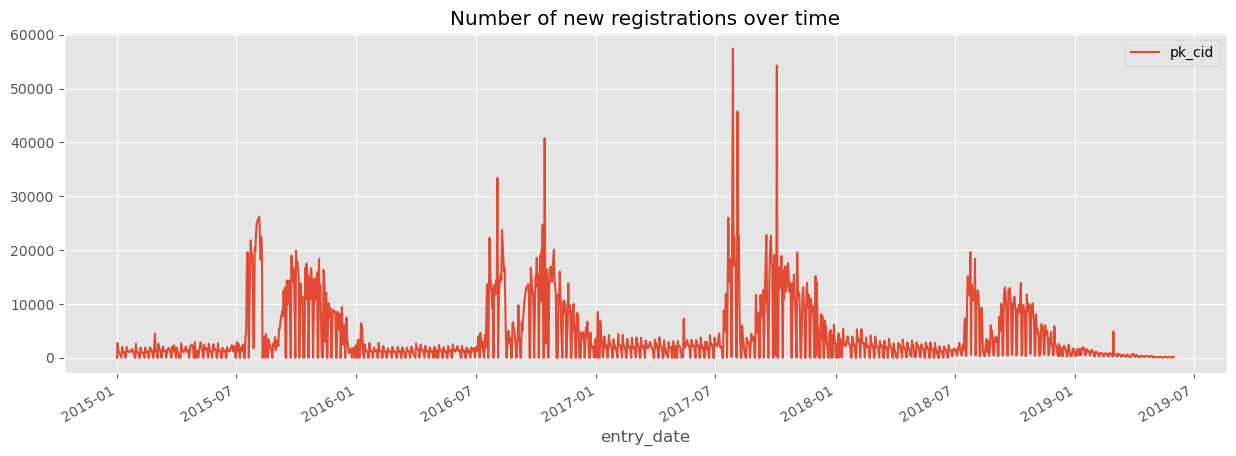

In [129]:
df.groupby("entry_date").agg({"pk_cid": "count"}).plot(figsize = (15, 5), title = "Number of new registrations over time")

<AxesSubplot:title={'center':'Userbase growth over time'}, xlabel='pk_partition'>

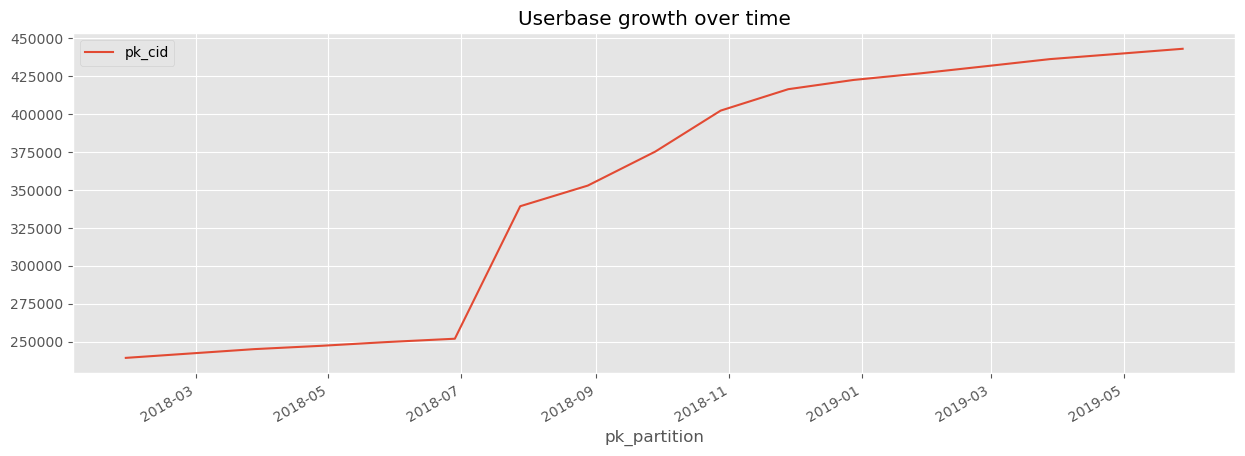

In [130]:
df.groupby("pk_partition").agg({"pk_cid": "count"}).plot(figsize = (15, 5), title = "Userbase growth over time")

<AxesSubplot:title={'center':'Age distribution'}>

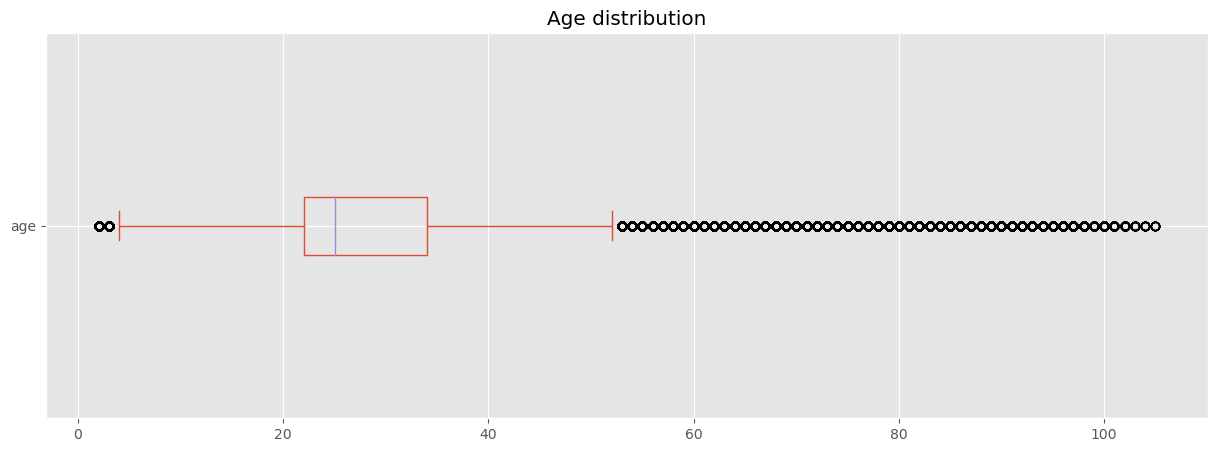

In [131]:
df["age"].plot(kind = "box",vert = False, figsize = (15, 5), title = "Age distribution")

<AxesSubplot:title={'center':'Age distribution'}, ylabel='Frequency'>

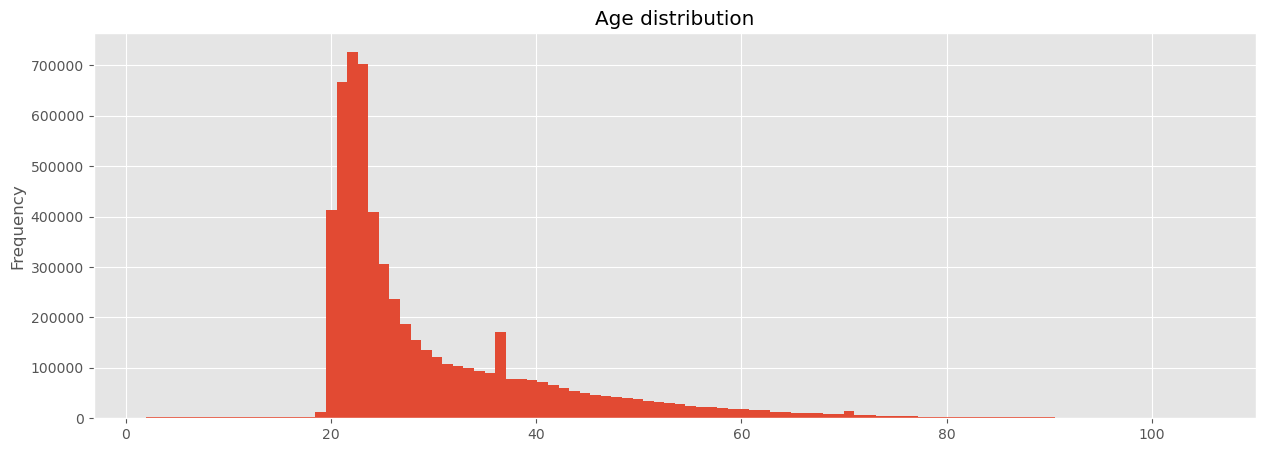

In [132]:
df["age"].plot(kind = "hist", bins = 100, figsize = (15, 5), title = "Age distribution")

In [133]:
outliers(pd.DataFrame(df["age"]))

df["age"]
Min: 2, Max: 105, Q1: 22.0, Q3: 34.0
IQR: 12.0
LOWER/UPPER Range: 4.0 / 52.0
Total LOWER/UPPER outliers: 2222 / 374788



<AxesSubplot:title={'center':'Distribution of salaries'}>

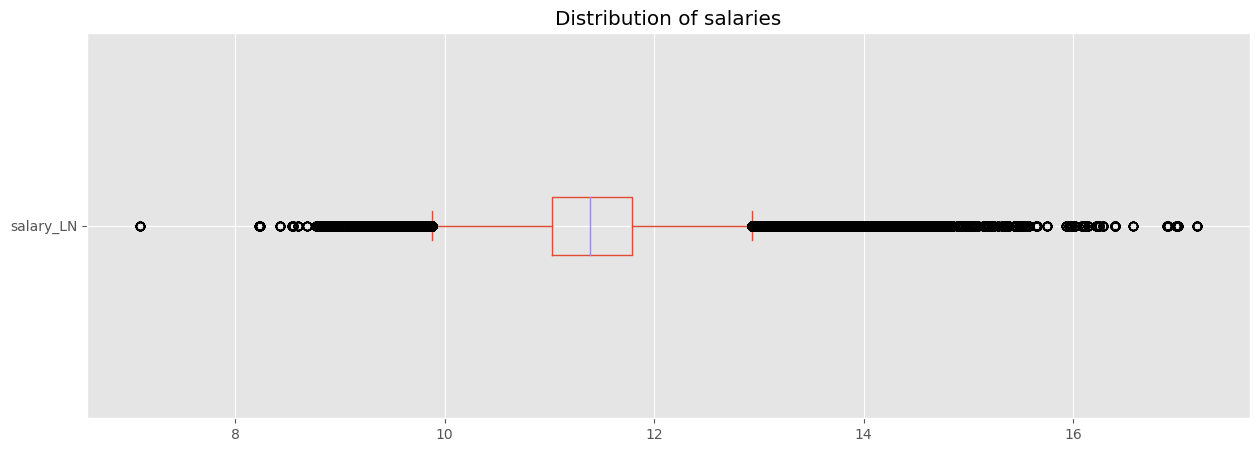

In [134]:
df["salary_LN"].plot(kind = "box",vert = False, figsize = (15, 5), title = "Distribution of salaries")

<AxesSubplot:title={'center':'Distribution of salaries'}, ylabel='Frequency'>

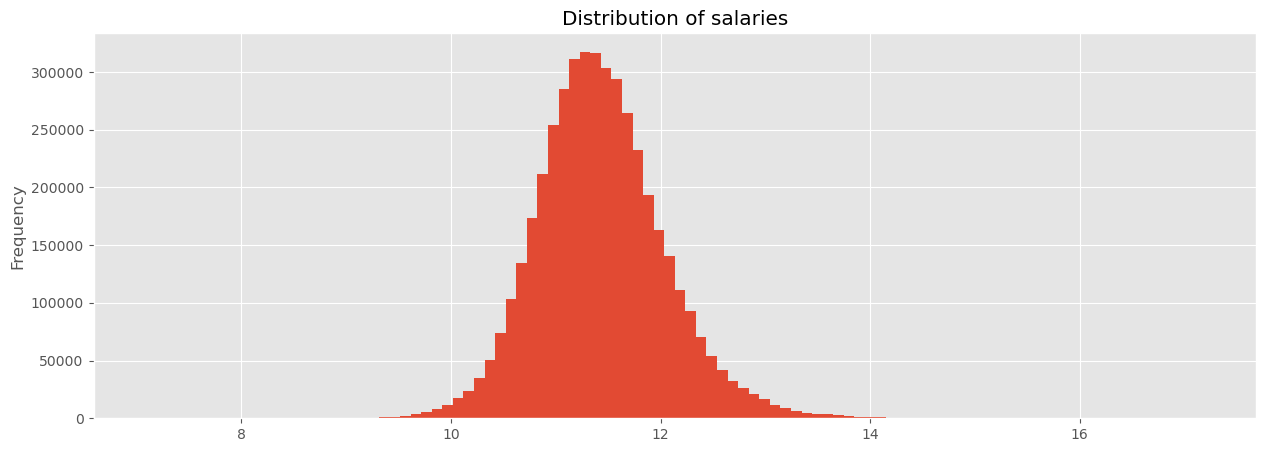

In [135]:
df["salary_LN"].plot(kind = "hist", bins = 100, figsize = (15, 5), title = "Distribution of salaries")

In [136]:
outliers(pd.DataFrame(df["salary"]))

df["salary"]
Min: 1202.73, Max: 28894395.51, Q1: 61500.63, Q3: 131669.91
IQR: 70169.28
LOWER/UPPER Range: -43753.29 / 236923.83000000002
Total LOWER/UPPER outliers: 0 / 284252



In [137]:
unique_values = df.nunique()
binary_features = unique_values[unique_values < 4].index.tolist()

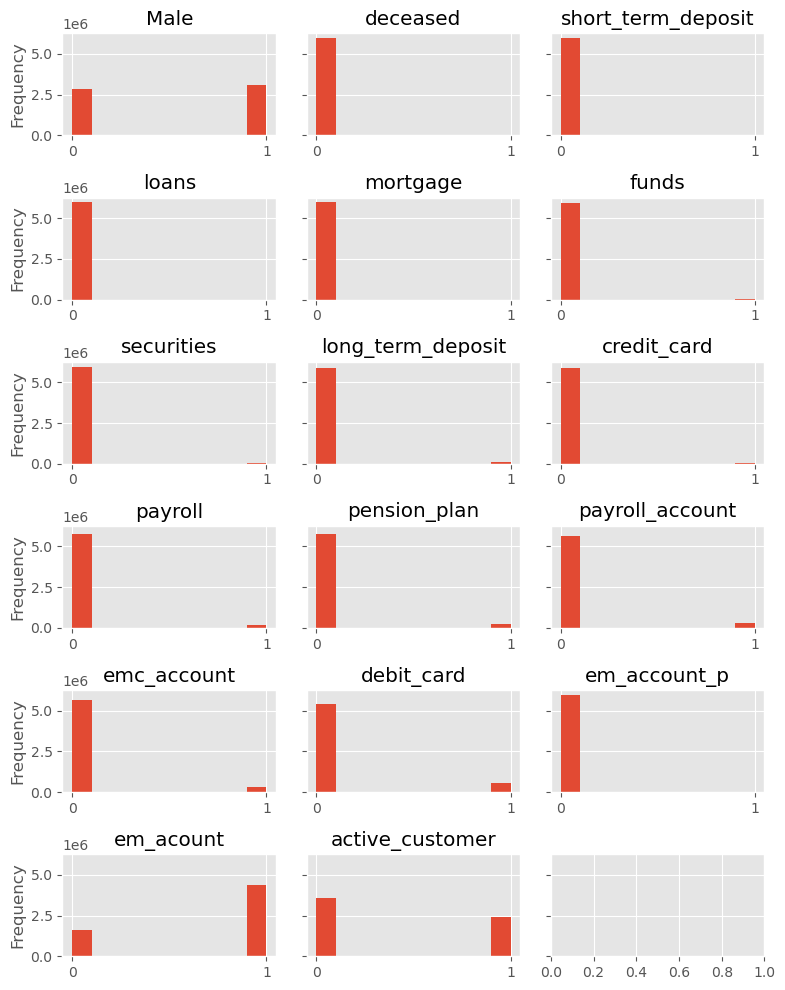

In [138]:
unique_values = df.nunique()
binary_features = unique_values[unique_values == 2].index.tolist()
n_features = len(binary_features)
rows = (n_features // 3) + (n_features % 3 != 0)
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (8, 10), sharey=True)

if rows > 1:
    ax = ax.flatten()
for i, column in enumerate(binary_features):
    df[column].plot(kind = "hist", ax=ax[i], title = column)
    ax[i].set_xticks([0, 1])

plt.tight_layout()
plt.show()

In [139]:
categorical_counter(df)

df["pk_cid"] contains 456373 unique values.
df["pk_partition"] contains 17 unique values.
df["country_id"] contains 41 unique values.
df["entry_date"] contains 1497 unique values.
df["entry_channel"] contains 69 unique values.
df["segment"] contains 4 unique values.
df["region"] contains 53 unique values.


In [140]:
products = ["short_term_deposit", "loans", "mortgage", "funds","securities", "long_term_deposit", "credit_card", "payroll", "pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount"]

In [141]:
x_y_size = {"salary": "mean", "age": "mean", "active_customer": "sum"}
four_feature_scatterer(df, "region", x_y_size, "Salary, Age and Active Customers by Region")

## Madrid: Most active customers, highest salaries, ages 33, salary average above 150k
## Barcelona follows closely
## Rest of active customers we can find majorly between 50 and 120k salary and 26-30 years old

In [142]:
subset = df[df["active_customer"] == 1]
x_y_size = {"salary": "mean", "age": "mean", "em_acount": "sum"}
four_feature_scatterer(subset, "region", x_y_size, "debit card vs credit card vs active customers by region")

## most active customers have a em_account, age/salary distribution tends to be similar to the whole df (bottom left cluster)

In [143]:
subset = df[df["active_customer"] == 1]
x_y_size = {"salary": "mean", "age": "mean", "pension_plan": "sum"}
four_feature_scatterer(subset, "region", x_y_size, "debit card vs credit card vs pension_plan by region")

In [144]:
subset = df[df["active_customer"] == 1]
x_y_size = {"debit_card": "mean", "credit_card": "mean", "em_acount": "sum"}
four_feature_scatterer(df, "region", x_y_size, "debit card vs credit card vs em_account by region")

## among active customers more perople have debit cards
## slight uptrend, if people have a debit card, they are more likely to have a credit card

In [145]:
x_y_size = {"credit_card": "sum", "age": "mean", "active_customer": "sum"}
four_feature_scatterer(df, "region", x_y_size, "Salary, Age and Active Customers by Region")

In [146]:
x_y_size = {"salary": "mean", "age": "mean", "active_customer": "sum"}
four_feature_scatterer(df, "entry_channel", x_y_size, "Salary, Age and Active Customers by Entry Channel")

In [147]:
x_y_size = {"salary": "mean", "age": "mean", "active_customer": "sum"}
four_feature_scatterer(df, "country_id", x_y_size, "Salary, Age and Active Customers by country")

## we have zero active customers in other countries (no matter what country ID means in the end)

In [148]:
x_y_size = {"salary": "mean", "age": "mean", "active_customer": "sum"}
four_feature_scatterer(df, "segment", x_y_size, "Salary, Age and Active Customers by Segment")

## my conclusion of the segment feature would be that someone tried to segment the customers by their salary and age, but it is not very clear. 
## Suggestion: Let's drop this feature and make our own segmentation 

In [149]:
#top 20 value counts

features = ["age", "entry_channel", "country_id", "region", "segment"]
df_prep = df.drop_duplicates(subset = "pk_cid", keep = "last")
sorted_counts = pd.DataFrame()

for feature in features:
    temp = pd.DataFrame(df_prep[feature].value_counts()).reset_index()
    temp = temp.sort_values(by = feature, ascending = False)
    sorted_counts = pd.concat([sorted_counts, temp], axis = 1, ignore_index = True)

sorted_counts.columns = ["age", "#", "entry", "#", "country", "#", "region", "#", "seg", "#"]
sorted_counts[:20]

,age,#,entry,#,country,#,region,#,seg,#
0,23,49772,KHE,"196,482.00",ES,"456,209.00",Madrid,"98,248.00",student,"287,566.00"
1,22,47875,KHQ,"76,110.00",GB,32.00,Barcelona,"46,159.00",regular,"152,299.00"
2,21,46740,KFC,"59,989.00",US,18.00,Valencia,"27,711.00",not_available,"8,952.00"
3,24,37394,KHM,"31,918.00",FR,15.00,Murcia,"21,747.00",top,"7,556.00"
4,20,25924,KAT,"26,942.00",CH,15.00,Sevilla,"21,309.00",NaN,NaN
5,25,23622,KHN,"17,028.00",DE,13.00,La Coruna,"18,132.00",NaN,NaN
6,26,18608,KHK,"16,891.00",BE,7.00,Malaga,"13,591.00",NaN,NaN
7,27,14944,not_available,"9,013.00",BR,6.00,Alicante,"13,471.00",NaN,NaN
8,28,12445,RED,"5,218.00",VE,5.00,Pontevedra,"12,659.00",NaN,NaN
9,29,10758,KFA,"5,106.00",MX,5.00,Cadiz,"11,741.00",NaN,NaN


# AGE vs binaries

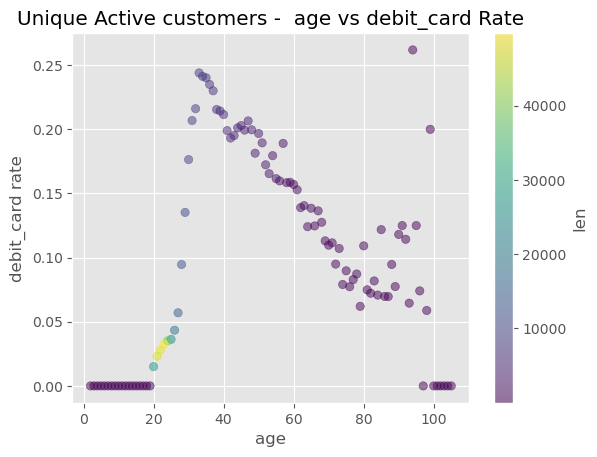

In [150]:
feature_vs_target_w_lengh(df, "age", "debit_card")

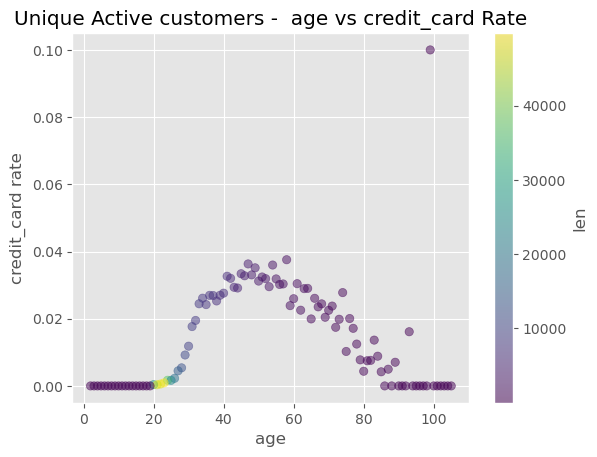

In [151]:
feature_vs_target_w_lengh(df, "age", "credit_card")

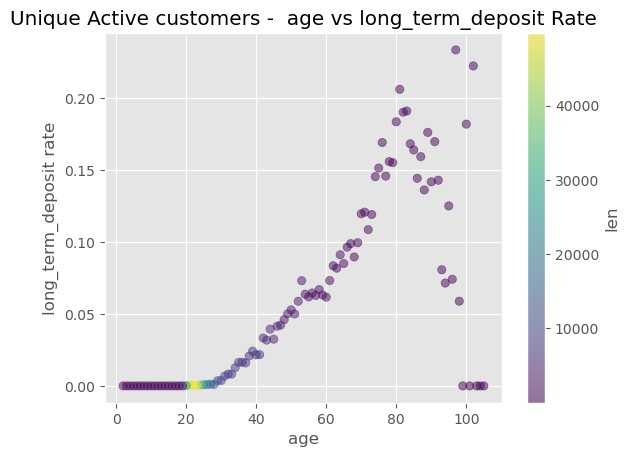

In [152]:
feature_vs_target_w_lengh(df, "age", "long_term_deposit")

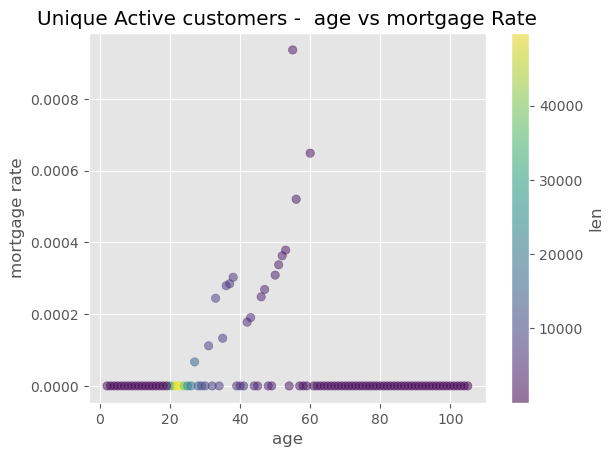

In [153]:
feature_vs_target_w_lengh(df, "age", "mortgage")

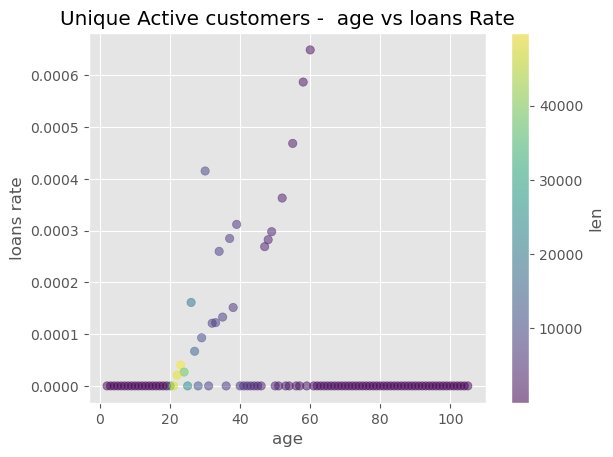

In [154]:
feature_vs_target_w_lengh(df, "age", "loans")

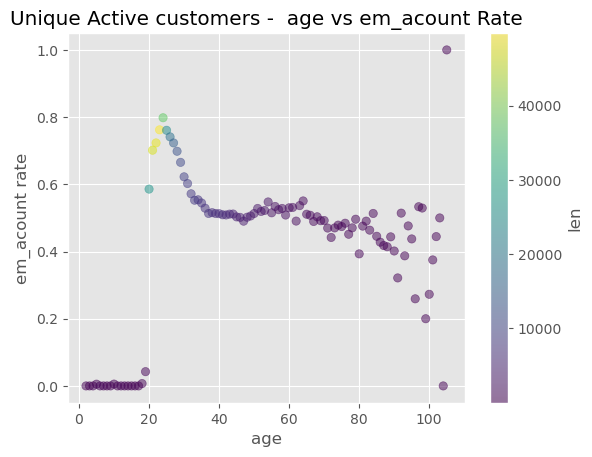

In [155]:
feature_vs_target_w_lengh(df, "age", "em_acount")

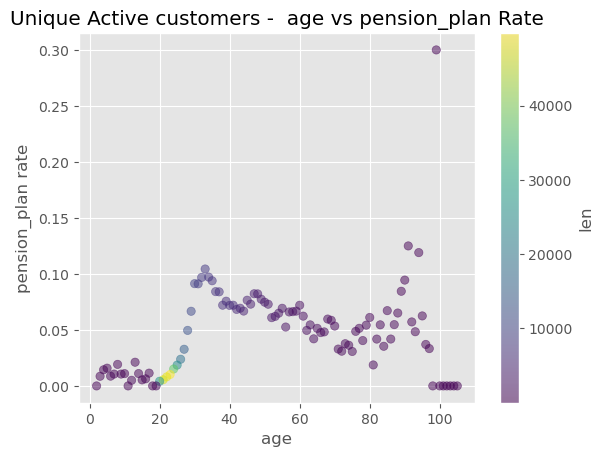

In [156]:
feature_vs_target_w_lengh(df, "age", "pension_plan")

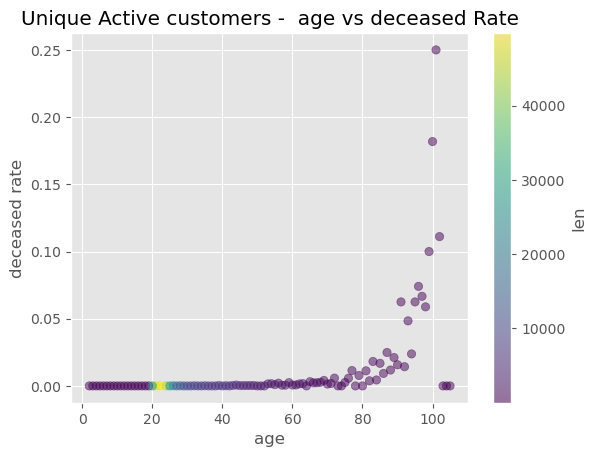

In [157]:
feature_vs_target_w_lengh(df, "age", "deceased")

# Salary (log) vs binaries

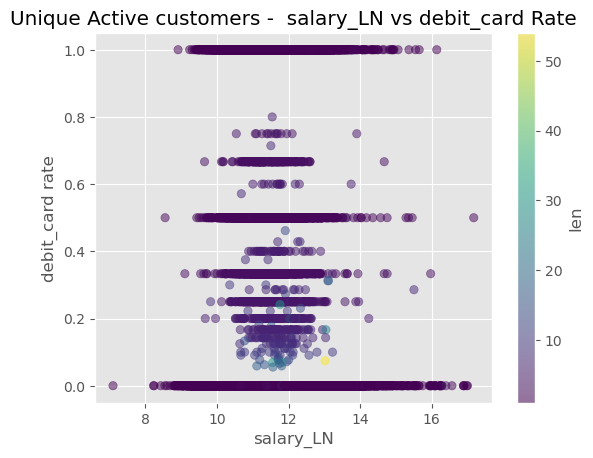

In [158]:
feature_vs_target_w_lengh(df, "salary_LN", "debit_card")

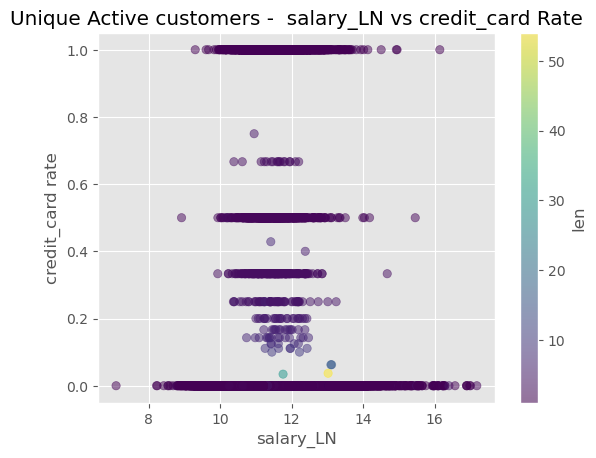

In [159]:
feature_vs_target_w_lengh(df, "salary_LN", "credit_card")

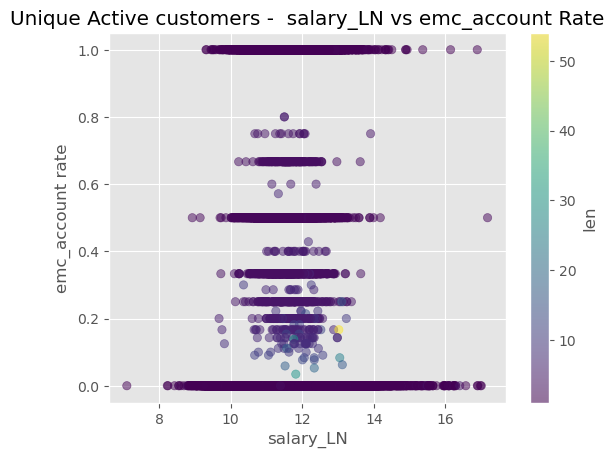

In [160]:
feature_vs_target_w_lengh(df, "salary_LN", "emc_account")

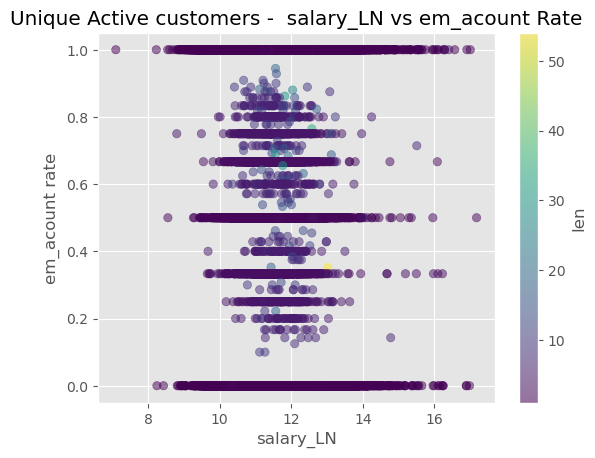

In [161]:
feature_vs_target_w_lengh(df, "salary_LN", "em_acount")

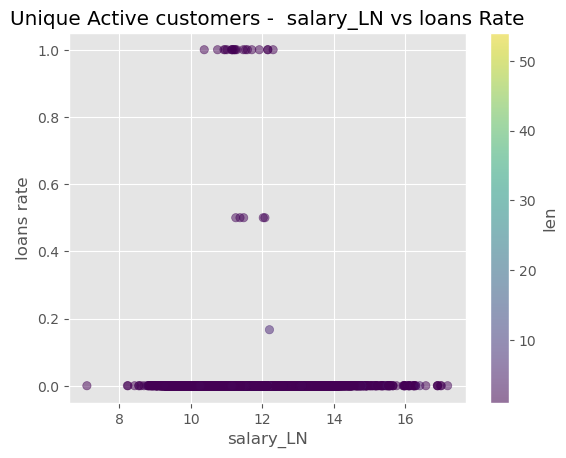

In [162]:
feature_vs_target_w_lengh(df, "salary_LN", "loans")

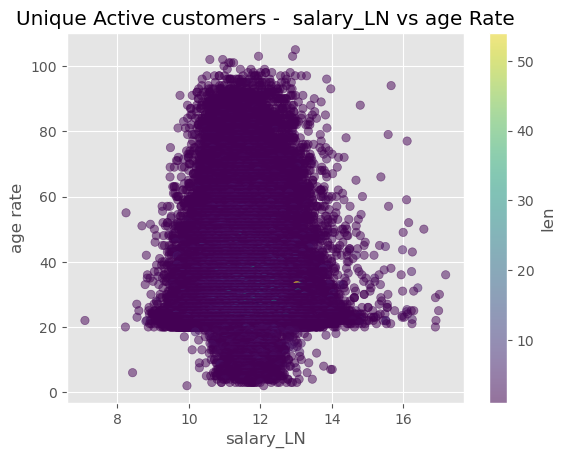

In [163]:
feature_vs_target_w_lengh(df, "salary_LN", "age")

# entry date vs binaries

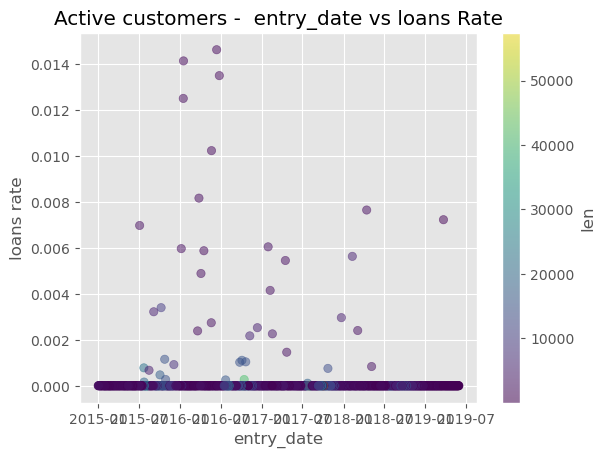

In [164]:
feature_vs_target_w_lengh(df, "entry_date", "loans", grouped = False)

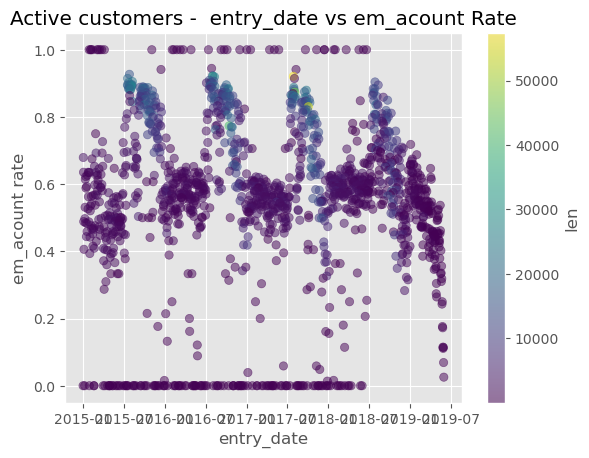

In [165]:
feature_vs_target_w_lengh(df, "entry_date", "em_acount", grouped = False)

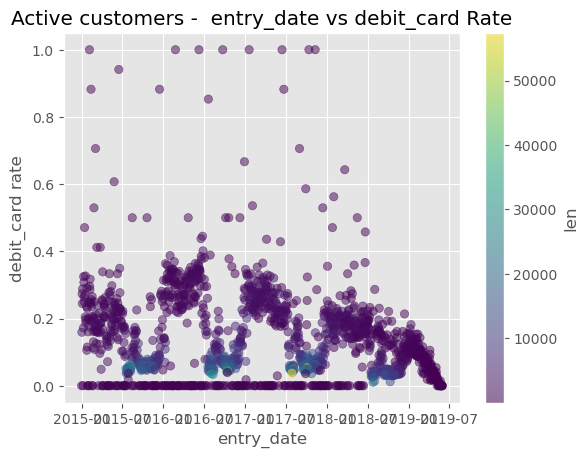

In [166]:
feature_vs_target_w_lengh(df, "entry_date", "debit_card", grouped = False)

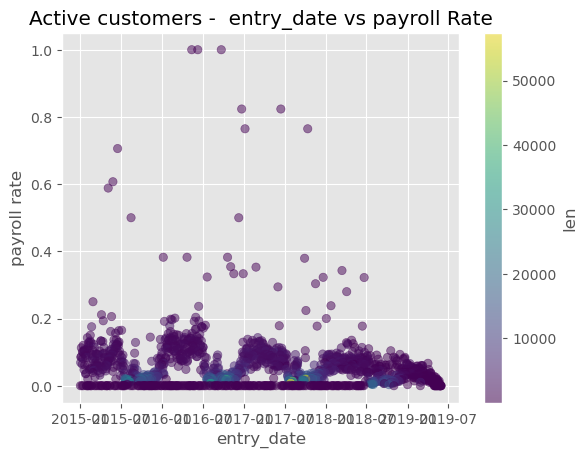

In [167]:
feature_vs_target_w_lengh(df, "entry_date", "payroll", grouped = False)

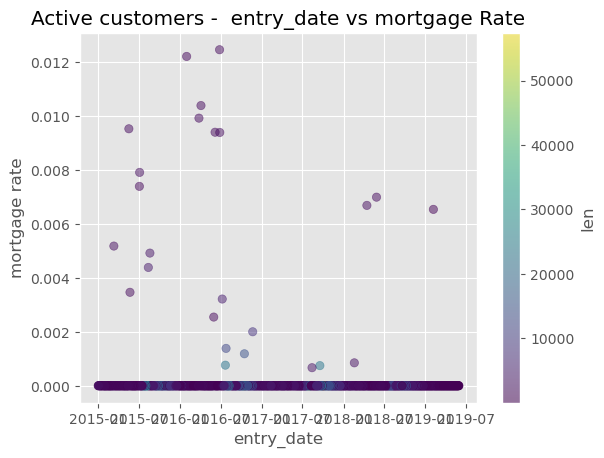

In [168]:
feature_vs_target_w_lengh(df, "entry_date", "mortgage", grouped = False)

In [169]:
df["em_acount"].value_counts()

1    4381602
0    1581322
Name: em_acount, dtype: int64

In [170]:
df[df["em_acount"] == 0]["pk_cid"].unique()[:30]

array(['1050613', '1050680', '1050693', '1050660', '1050642', '1050651',
       '1050652', '1050658', '1050659', '1050553', '1050565', '1050537',
       '1050857', '1050869', '1050911', '1050914', '1050920', '1050141',
       '1050091', '1050155', '1050389', '1050337', '1050360', '1050358',
       '1051851', '1051852', '1051853', '1051854', '1051920', '1051968'],
      dtype=object)

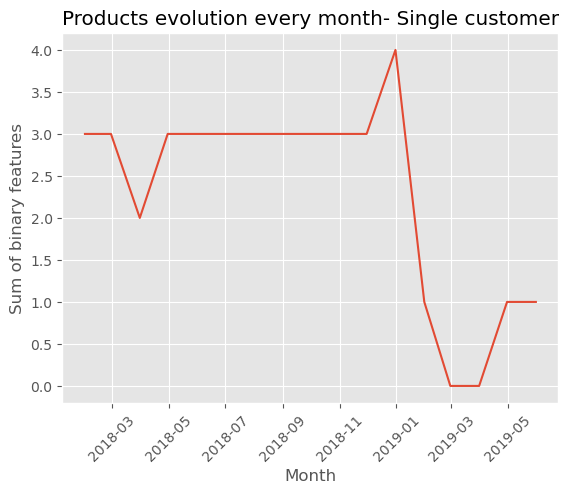

In [171]:
## this way we can see if and when something changed in a customer's account

df_monthly = df[df["pk_cid"] == "1050358"].resample("M", on = "pk_partition").sum()
plt.plot(df_monthly.index, df_monthly[["short_term_deposit", "loans", "mortgage", "funds","securities", "long_term_deposit", "credit_card", "payroll","pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount"]].sum(axis = 1))

plt.xlabel("Month")
plt.ylabel("Sum of binary features")
plt.title("Products evolution every month- Single customer")
plt.xticks(rotation=45)
plt.show()

In [172]:
df[df["pk_cid"] == "1050358"].T

,606,473364,693955,969315,1007575,1258629,1583493,2050193,2330537,2673371,3335322,3416664,4163025,4547377,5074378,5270466,5775321
pk_cid,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358,1050358
pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00
country_id,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES,ES
Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
age,31,31,31,31,31,31,31,31,31,32,32,32,32,32,32,32,32
deceased,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
salary,"70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48","70,641.48"
short_term_deposit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
loans,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mortgage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<br>

# What happened on July/2018? Why the drop?

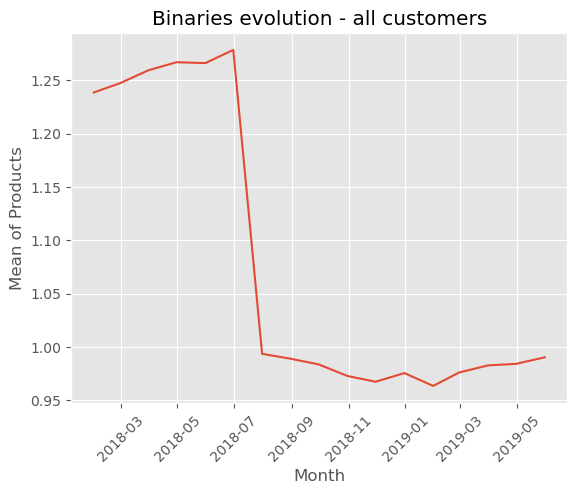

In [173]:
## in june 2018 something happened: the average sum of binary features dropped significantly

df_monthly = df.resample("M", on = "pk_partition").mean()
plt.plot(df_monthly.index, df_monthly[["short_term_deposit", "loans", "mortgage", "funds","securities", "long_term_deposit", "credit_card", "payroll","pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount"]].sum(axis = 1))

plt.xlabel("Month")
plt.ylabel("Mean of Products")
plt.title("Binaries evolution - all customers")
plt.xticks(rotation=45)
plt.show()

## product analysis


<AxesSubplot:title={'center':'Userbase growth over time'}, xlabel='pk_partition'>

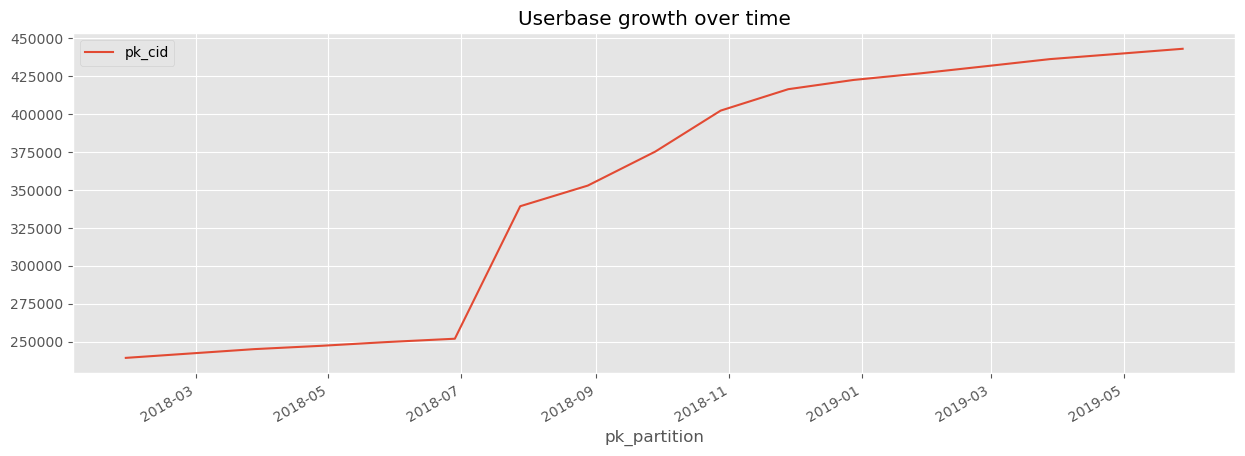

In [174]:
df.groupby("pk_partition").agg({"pk_cid": "count"}).plot(figsize = (15, 5), title = "Userbase growth over time")

In [175]:
products = ["short_term_deposit", "loans", "mortgage", "funds","securities", "long_term_deposit", "credit_card", "payroll","pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount"]
products_no_em = [prod for prod in products if prod != "em_acount"]

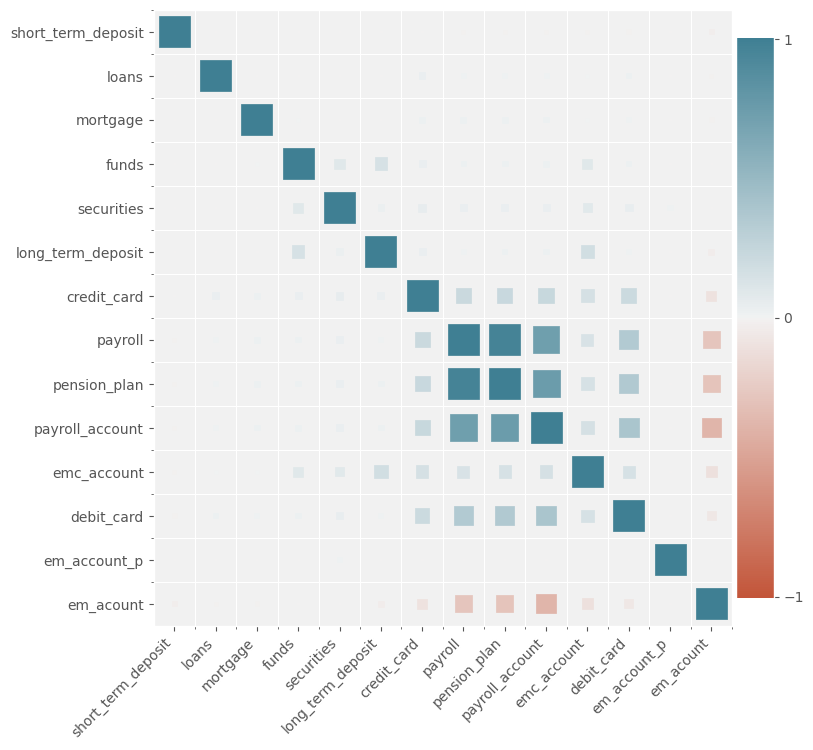

In [176]:
plt.figure(figsize = (8, 8))
corrplot(df[products].corr(), size_scale = 500)

In [177]:
df_ts = df.copy(deep = True)
df_ts.set_index("pk_partition", inplace = True)
scaler = MinMaxScaler()
products_plans = ["pension_plan", "securities", "short_term_deposit", "long_term_deposit", "funds"]
products_invest = ["loans", "mortgage", "debit_card", "credit_card"]
product_accounts = ["payroll", "payroll_account", "em_account_p", "em_acount" , "emc_account"]

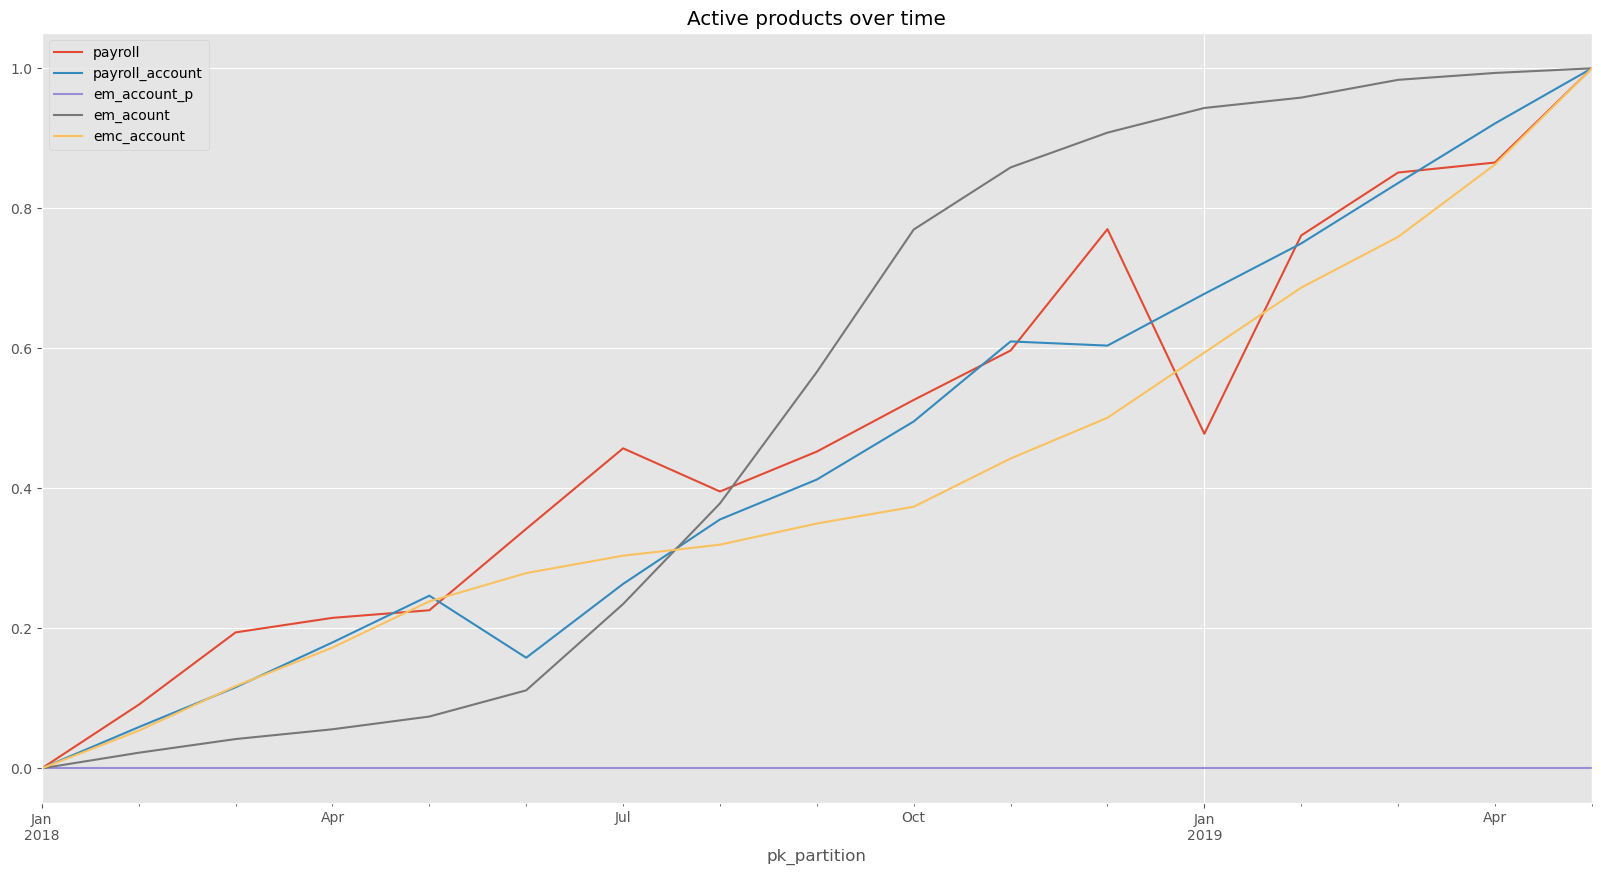

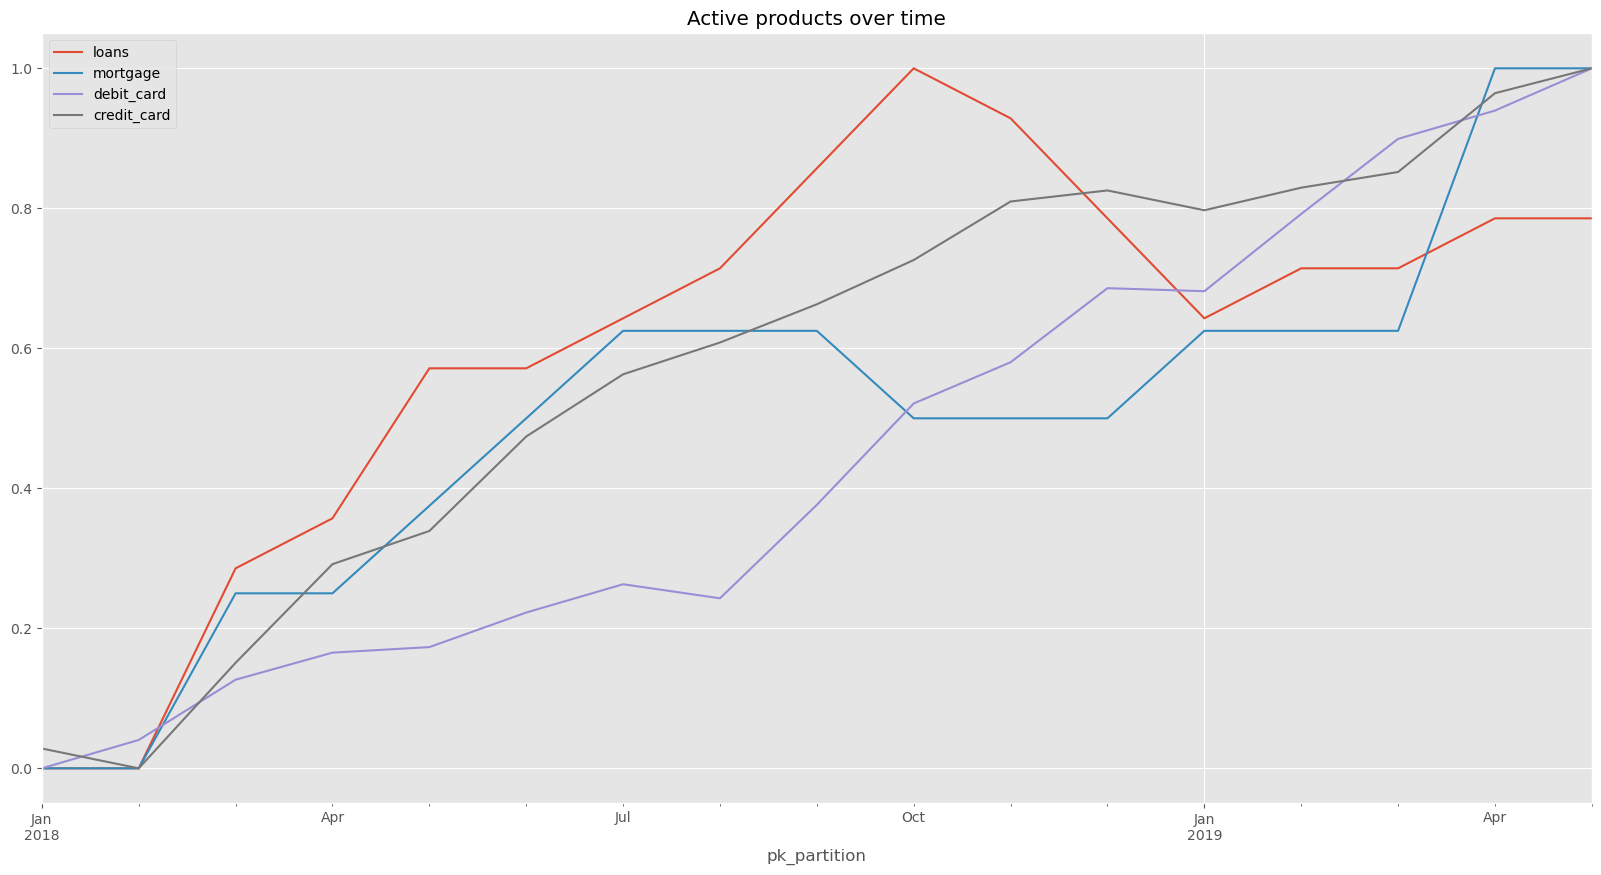

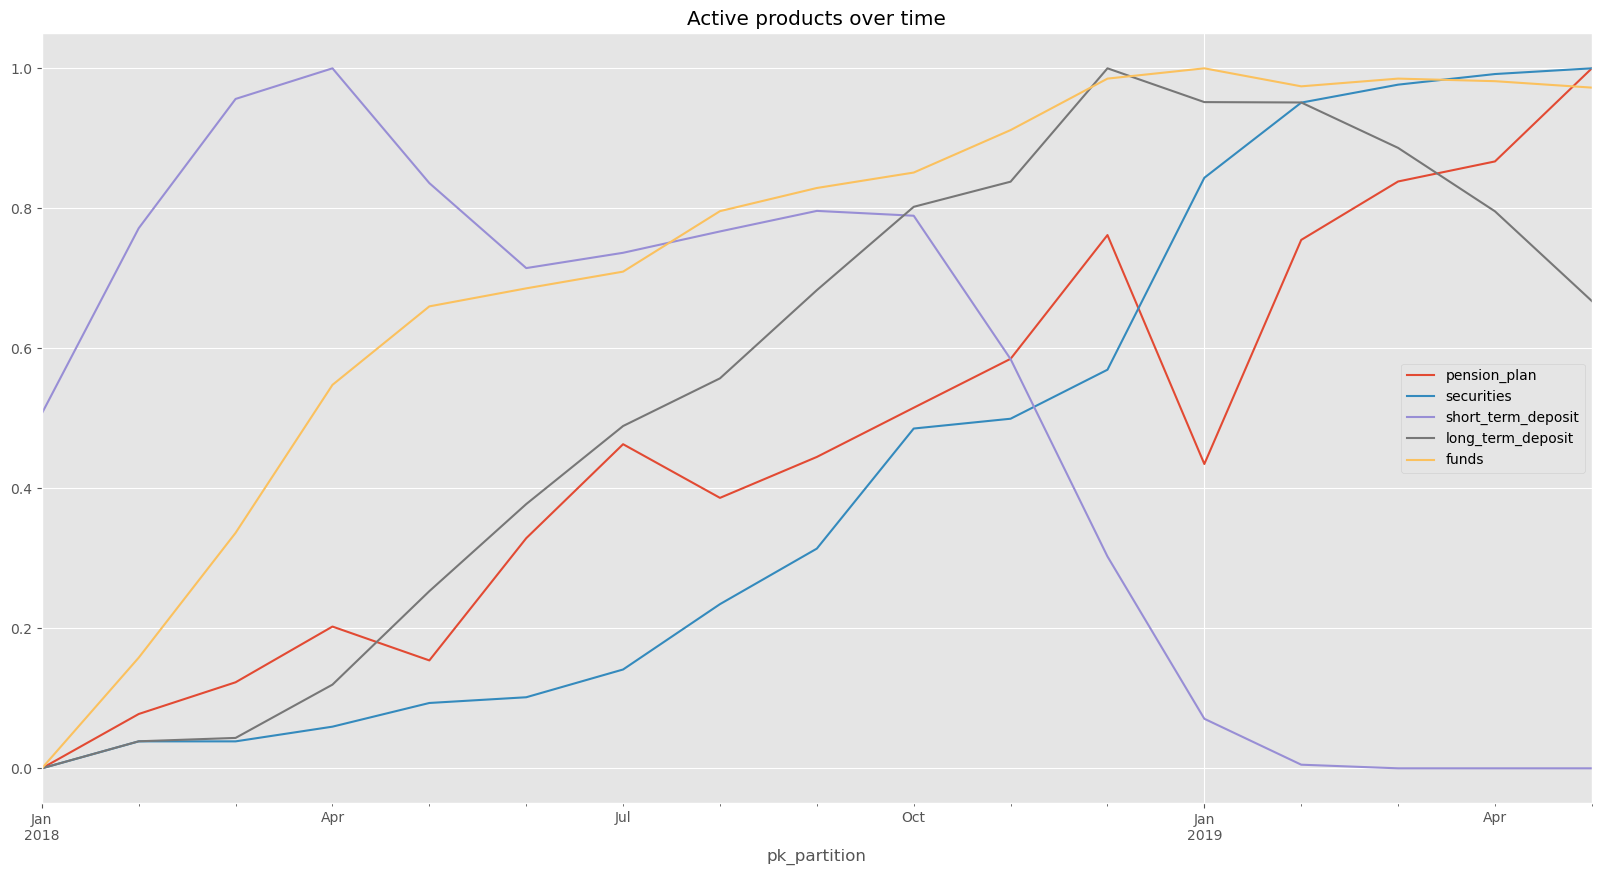

In [178]:
for p_list in [product_accounts, products_invest, products_plans]:
    fig, ax = plt.subplots(figsize = (20, 10))
    for i, product in enumerate(p_list):
        df_grouped = df.groupby("pk_partition").agg({product: "sum"})
        df_grouped = df_grouped.resample("M").sum()
        df_grouped.reset_index(inplace = True)
        df_grouped[product] = scaler.fit_transform(df_grouped[[product]])
        df_grouped.plot(ax = ax, x = "pk_partition", y = product, label = product, legend = True)
        plt.title("Active products over time")
    plt.show()

<Figure size 2000x1000 with 0 Axes>

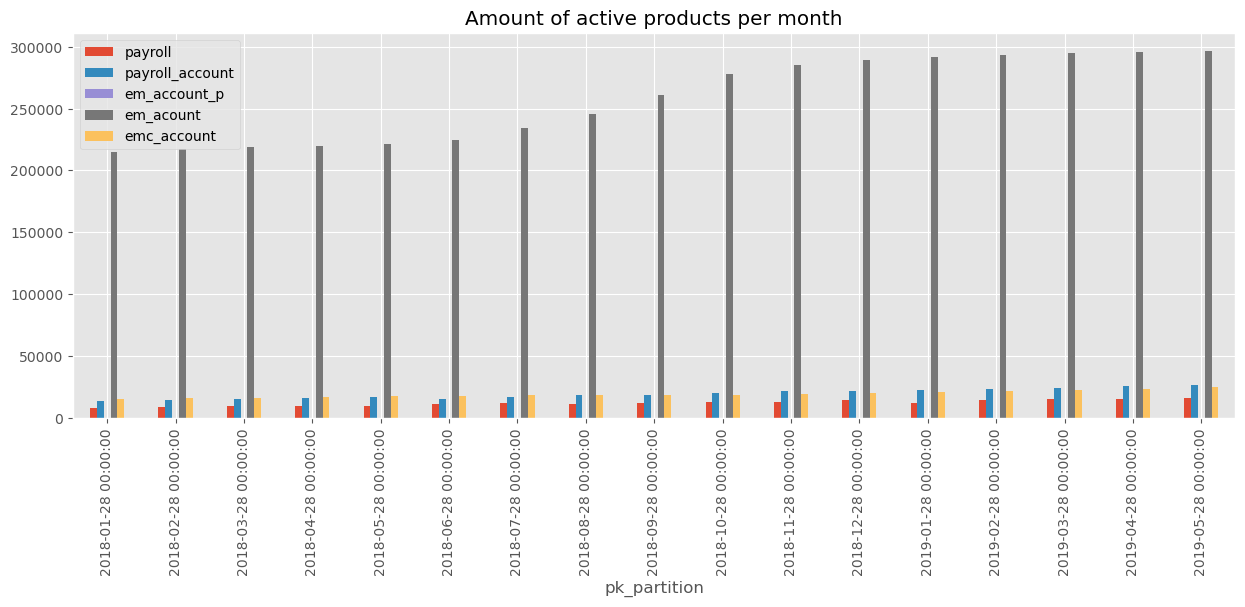

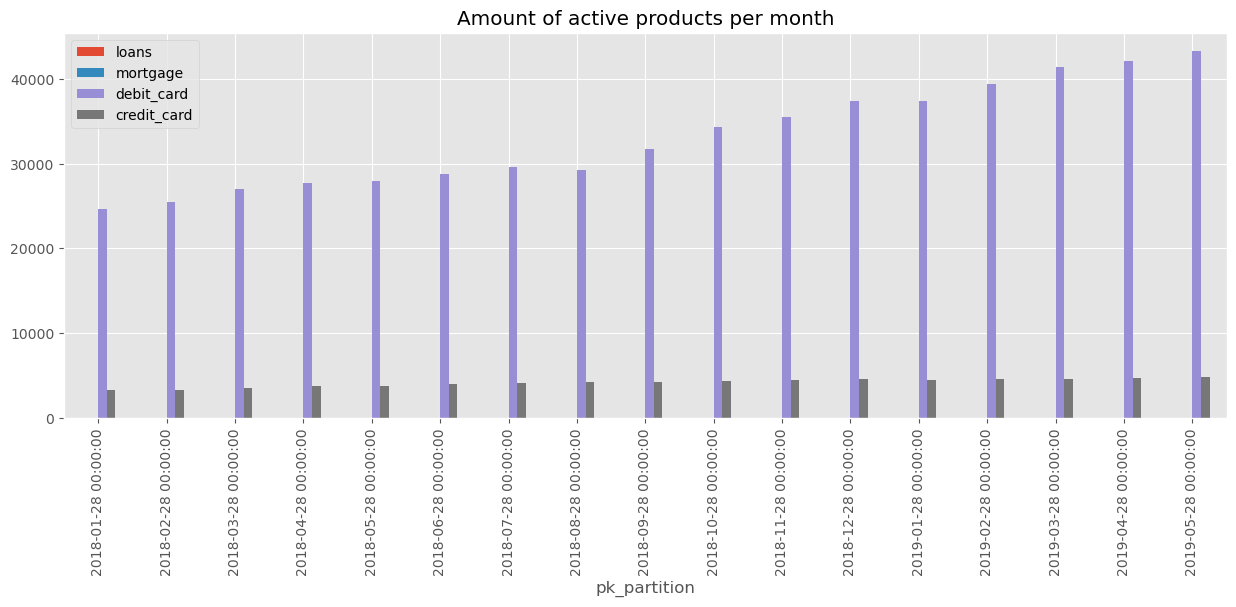

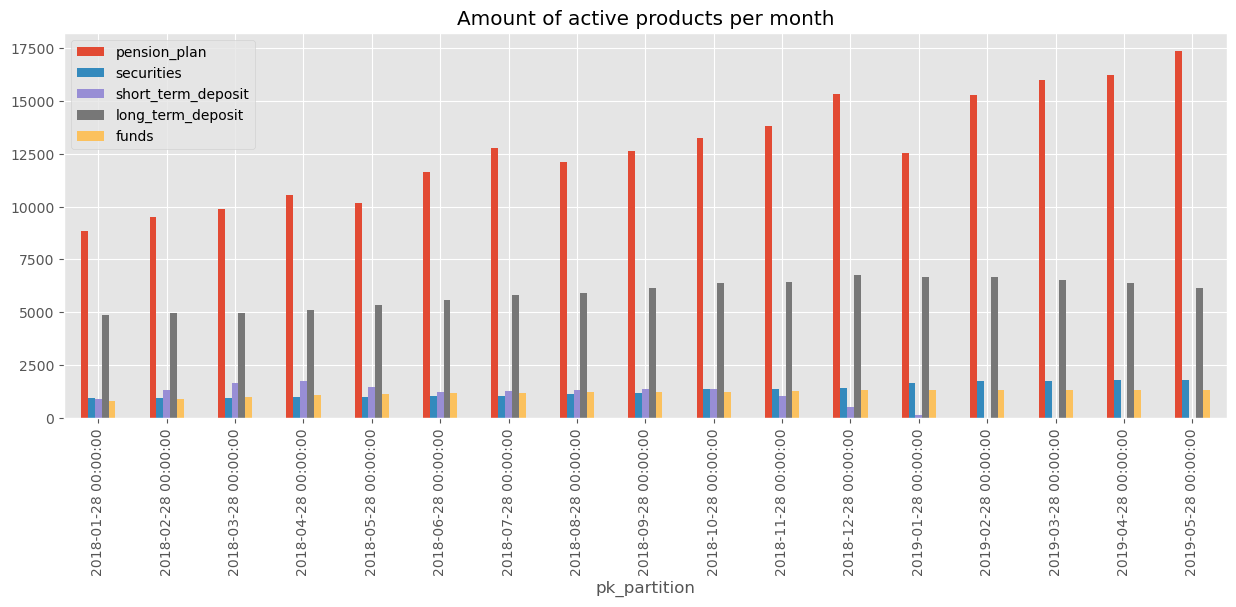

In [179]:
fig, ax = plt.subplots(figsize = (20, 10))
plt.clf()
for p_list in [product_accounts, products_invest, products_plans]:
    agg_func = {product: "sum" for product in p_list}
    df_ts.groupby("pk_partition").agg(agg_func).plot(kind = "bar", figsize = (15, 5))
    plt.title("Amount of active products per month")
    plt.show()

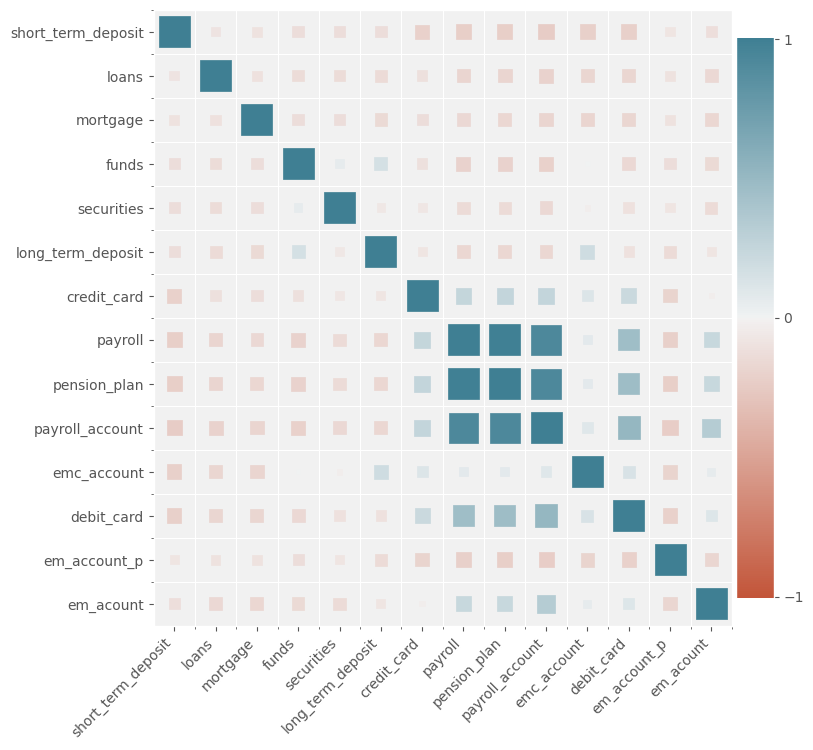

In [180]:
products = ["short_term_deposit", "loans", "mortgage", "funds","securities", "long_term_deposit", "credit_card", "payroll","pension_plan", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount"]

df_diff = df_ts[products].diff().dropna()
df_diff[df_diff != 0] = 1

plt.figure(figsize = (8, 8))
corrplot(df_diff.corr().corr(), size_scale = 500)


## payroll, payroll_account and pension_plan are highly correlated.
## when the product status of one of them changes, one or two of the others almost always change as well.
## debit card has some correlation with the 3 above as well

<AxesSubplot:title={'center':'Salary mean over time [all users]'}, xlabel='pk_partition'>

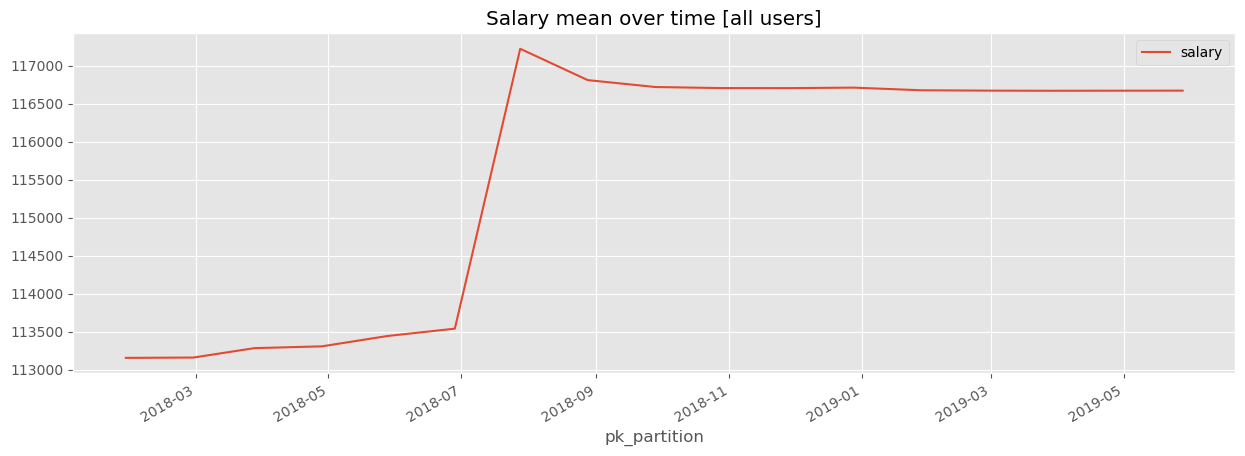

In [181]:
df.groupby("pk_partition").agg({"salary": "mean"}).plot(figsize = (15, 5), title = "Salary mean over time [all users]")

## → salary seems to be a unchanged variable. Users have the option (?) to to submit their salary on registration. The value will not be updated afterwards.

<AxesSubplot:title={'center':'Active customer rate over time [all users]'}, xlabel='pk_partition'>

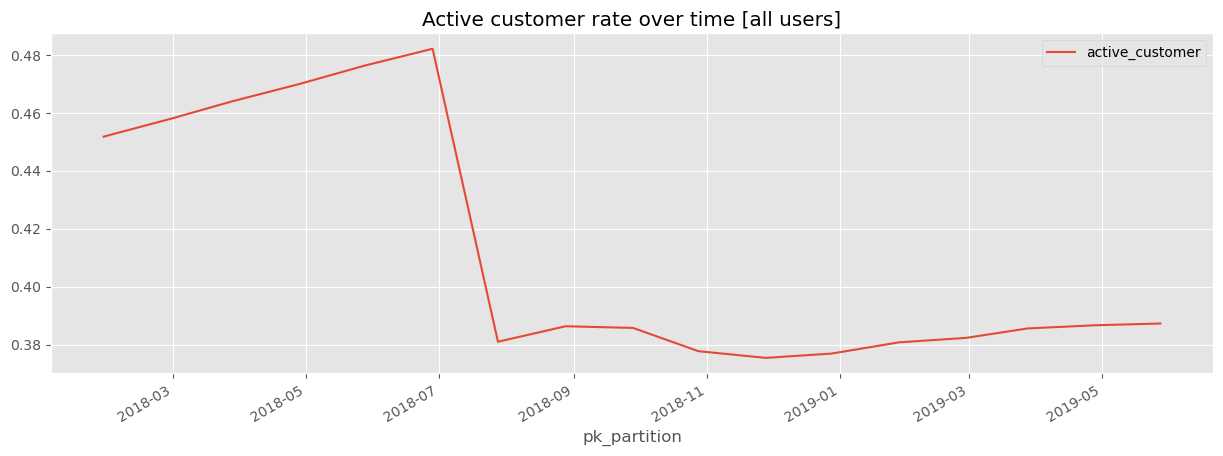

In [182]:
df.groupby("pk_partition").agg({"active_customer": "mean"}).plot(figsize = (15, 5), title = "Active customer rate over time [all users]")

<AxesSubplot:title={'center':'Active customer growth over time'}, xlabel='pk_partition'>

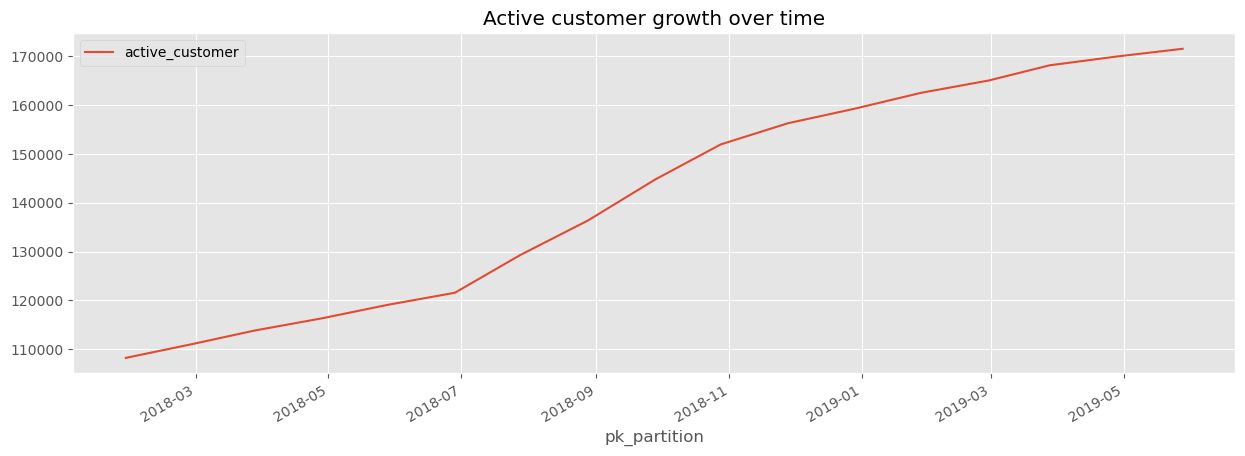

In [183]:
df.groupby("pk_partition").agg({"active_customer": "sum"}).plot(figsize = (15, 5), title = "Active customer growth over time")

## amount of sales per month

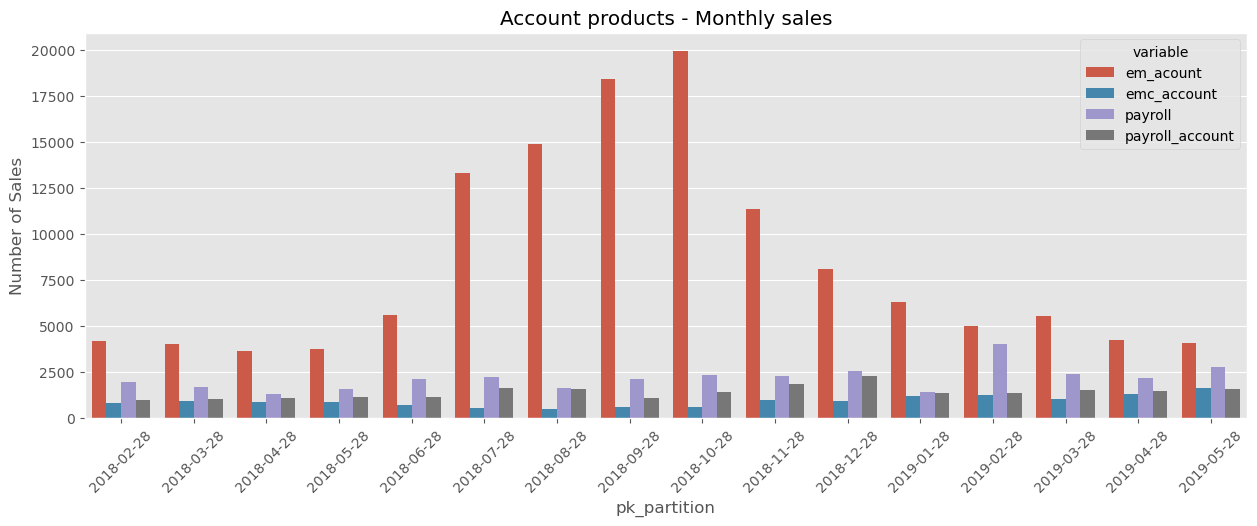

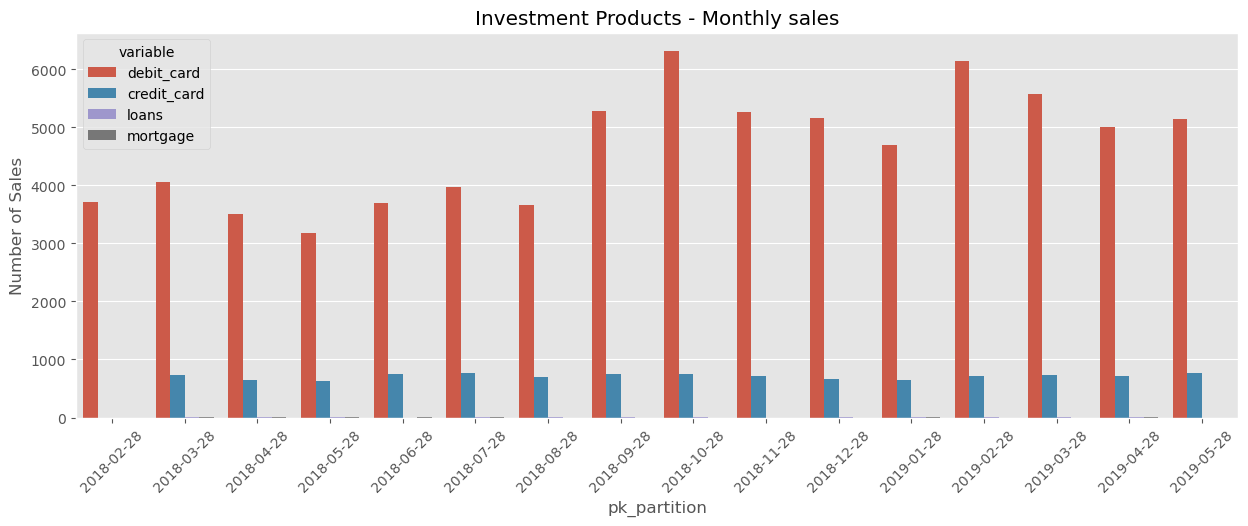

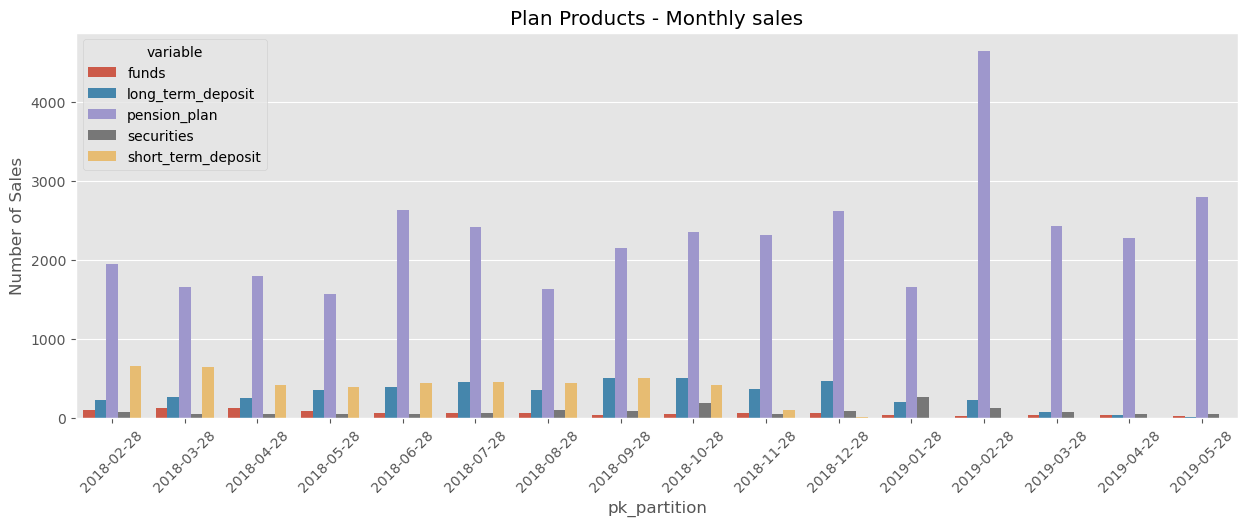

In [370]:
def monthly_sales_bars(data, product_list, title):

    cols = ["pk_cid"] + product_list
    df__ = data.reset_index().melt(id_vars = ["pk_partition", "pk_cid"], value_vars = product_list)
    
    df__ = df__[(df__["value"] == 1) & (df__.groupby("pk_cid")["value"].shift() == 0)]
    result = df__.groupby(["pk_partition", "variable"])["pk_cid"].nunique().reset_index(name = "sales")
    result["pk_partition"] = result["pk_partition"].astype(str)
    
    plt.figure(figsize = (15, 5))
    sns.barplot(x = "pk_partition", y = "sales", hue = "variable", data = result.iloc[4:])
    plt.ylabel("Number of Sales")
    plt.title(f"{title} - Monthly sales")
    plt.xticks(rotation = 45)
    plt.show()

    return result.iloc[4:]
    
account_sales = monthly_sales_bars(df_ts, product_accounts, "Account products")
invest_sales = monthly_sales_bars(df_ts, products_invest, "Investment Products")
plan_sales = monthly_sales_bars(df_ts, products_plans, "Plan Products")

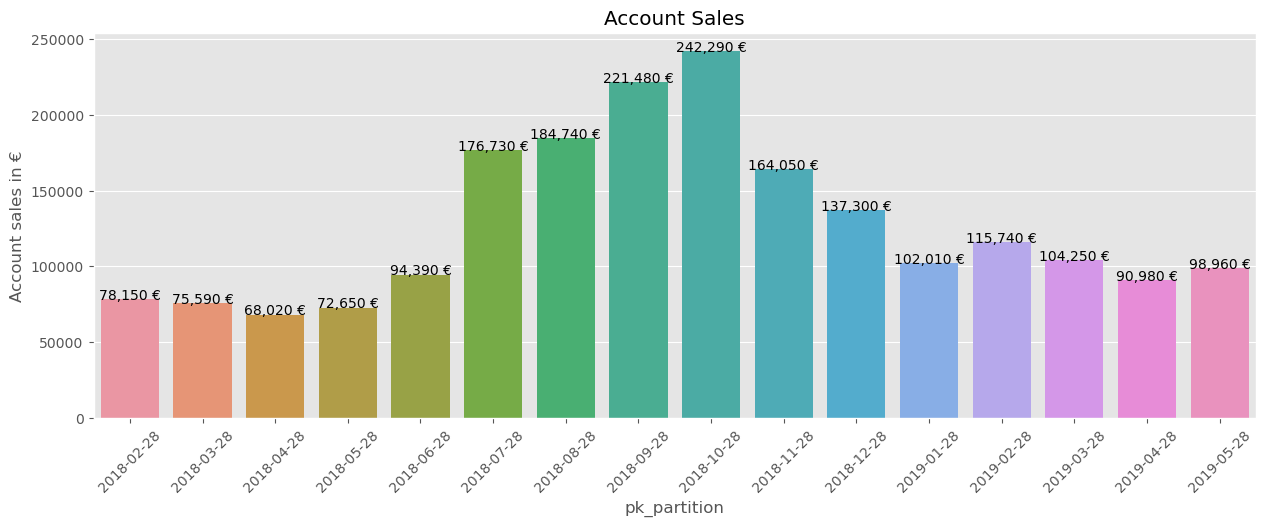

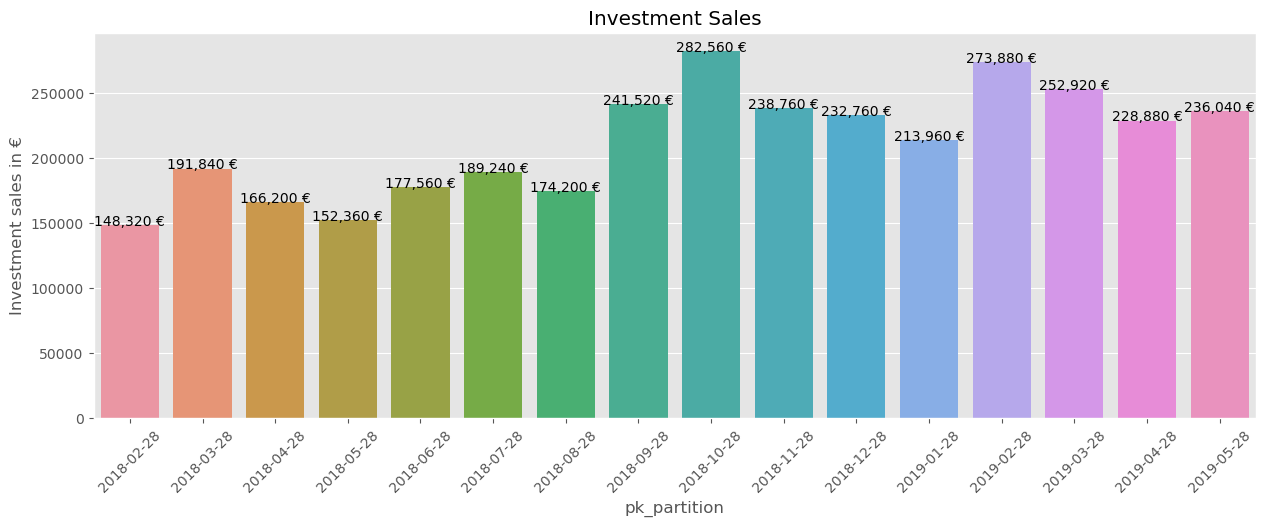

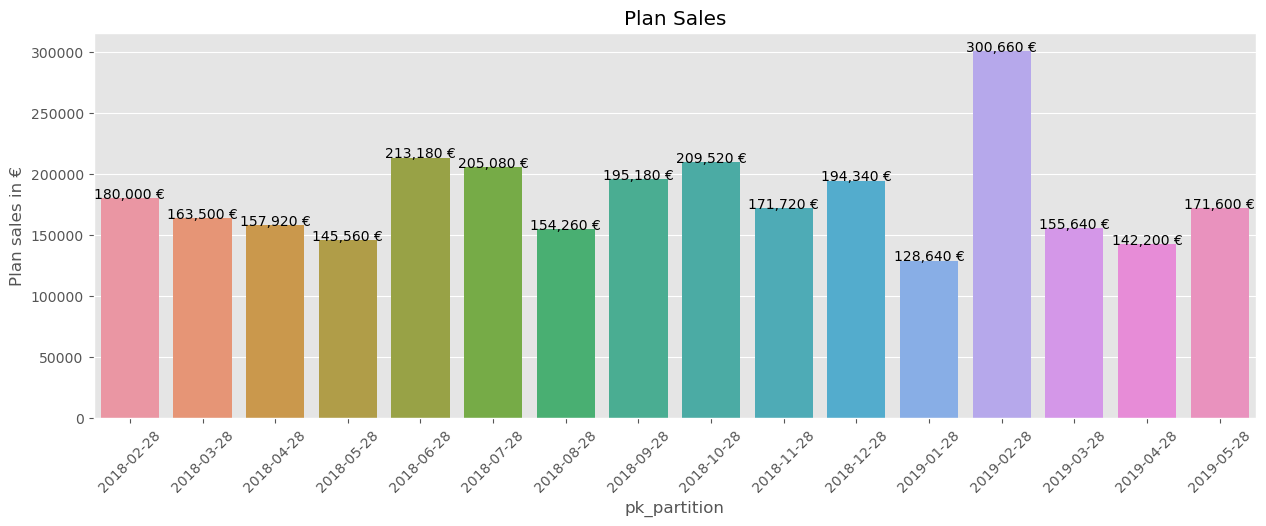

In [410]:
def revenue_plotter(data, category, multi, title):
    plot_df = data.groupby(category)["sales"].sum() * multi

    plt.figure(figsize = (15,5))
    sns.barplot(x = plot_df.index, y = plot_df.values)
    for i in range(len(plot_df)):
        plt.text(i, plot_df.values[i], "{:,}".format((int(plot_df.values[i]))) + " €", ha = "center", color = "black")
    
    plt.ylabel(f"{title} sales in €")
    plt.title(f"{title} Sales")
    plt.xticks(rotation = 45)
    plt.show()

revenue_plotter(account_sales, "pk_partition", 10, "Account")
revenue_plotter(invest_sales, "pk_partition", 40, "Investment")
revenue_plotter(plan_sales, "pk_partition", 60, "Plan")

In [411]:
acc_total = "{:,}".format(
    (account_sales.groupby("pk_partition")["sales"].sum() * 10).sum())
inv_total = "{:,}".format(
    (invest_sales.groupby("pk_partition")["sales"].sum() * 40).sum())
plan_total = "{:,}".format(
    (plan_sales.groupby("pk_partition")["sales"].sum() * 60).sum())

print(f"Total revenue from account products: {acc_total} €")
print(f"Total revenue from investment products: {inv_total} €")
print(f"Total revenue from plan products: {plan_total} €")

Total revenue from account products: 2,027,330 €
Total revenue from investment products: 3,401,000 €
Total revenue from plan products: 2,889,000 €


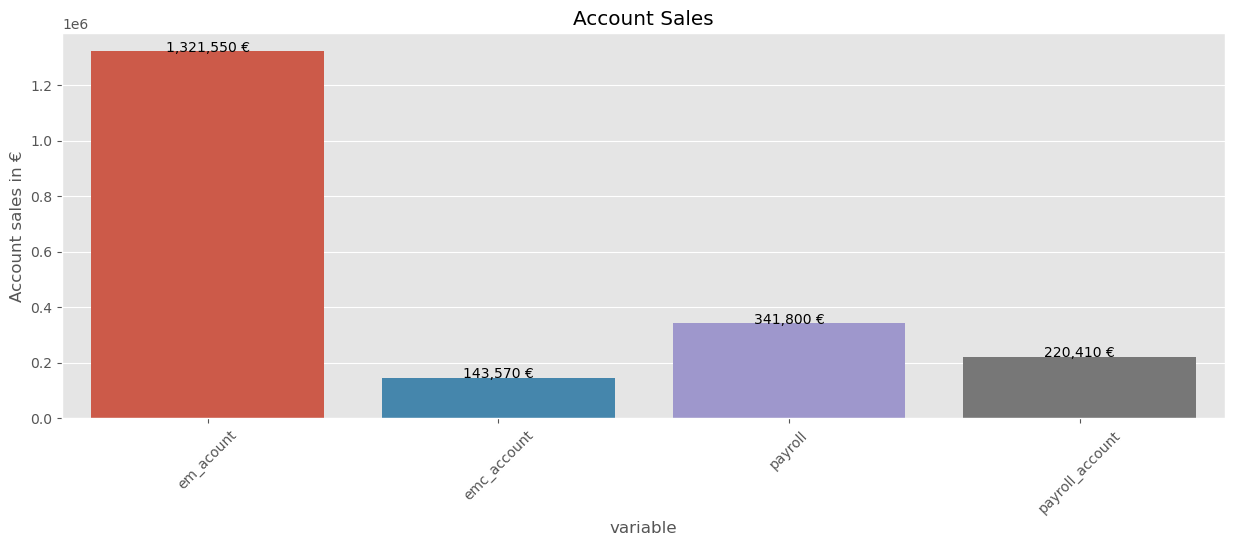

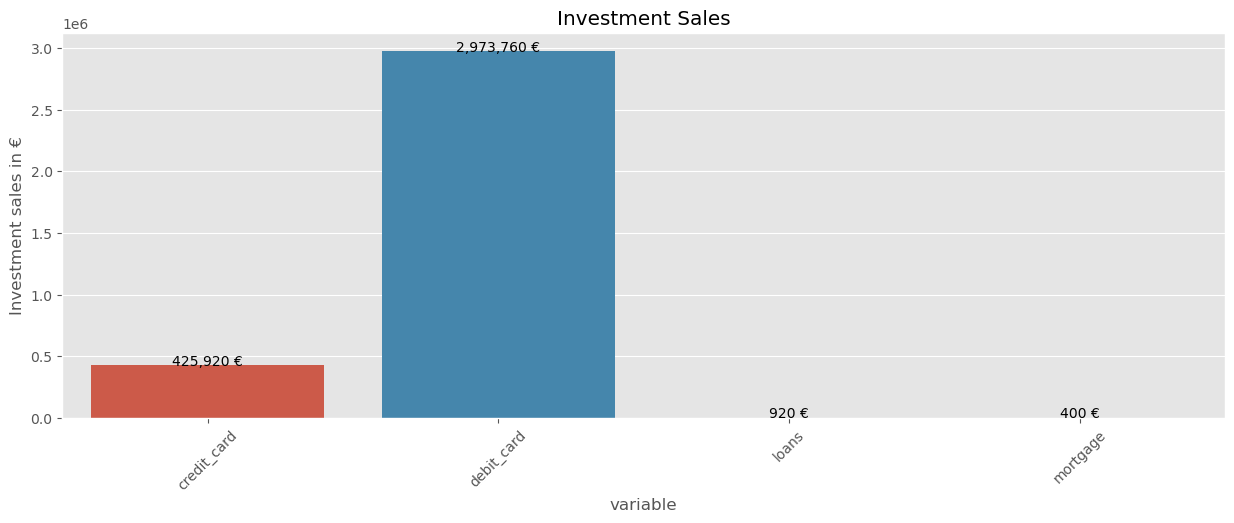

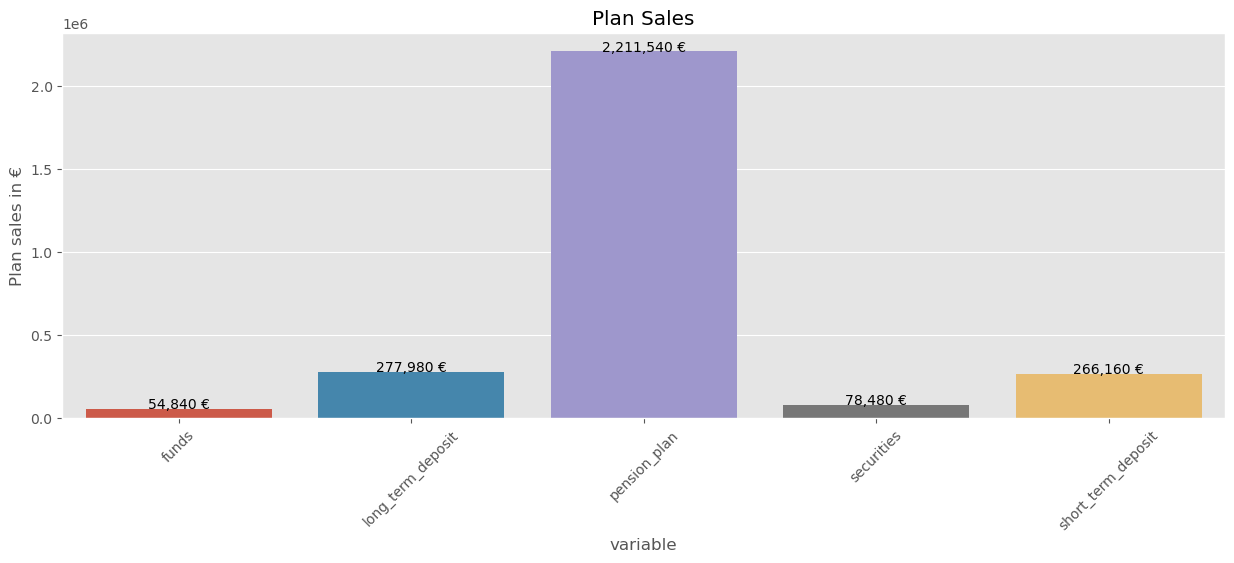

In [412]:
revenue_plotter(account_sales, "variable", 10, "Account")
revenue_plotter(invest_sales, "variable", 40, "Investment")
revenue_plotter(plan_sales, "variable", 60, "Plan")